# Anti Money Laundering (AML)

Money laundering is the process used to disguise the source of money or assets derived from criminal activity. Money laundering involves approximately $\$ 590$ billion to $\$ 1.5$ trillion USD per year worldwide. In 2018, $\$46.7$ billion was laundered through Canada with $\$7.4$ billion accounted in British Columbia. Canadian real state is a prime target for money laundering. For banks, it is important to comply the legislation from FINTRAC and OSFI. 

In terms of the model, it is important to reduce the false positive alarms while having very low tolerance to false negatives. False negatives, are critical because they may be problematic for the bank in terms of legislation and affect the reputation of the bank. It is important to analyze the context of the transactions/users relationships to improve effectiveness of the alarms. 



# Data: Elliptic Data Set

The [Elliptic Dataset](https://www.groundai.com/project/anti-money-laundering-in-bitcoin-experimenting-with-graph-convolutional-networks-for-financial-forensics/1) is a graph network of Bitcoin transactions with handcrafted features. All features are constructed using only publicly available information. 

The Elliptic DataSet maps Bitcoin transactions to real entities in two categories:
* Licit: exchanges, wallet providers, miners, licit services, etc.
* Ilicit: scams, malware, terrorist, organization, ransomware, Ponzi shcemes, etc

A given transaction is licit if the entity that generated it was licit.

- *Nodes and Edges* 203,769 node transactions and 234,355 directed edge payments flows. 2% are ilicit (Class 1), 21% are licit (Class 2)
- *Features* Each node has associated 166 features. 94 represent local information (timestep, number of inputs/outputs, transaction fee, output volume and aggregated figures) and 72 features represent aggregated features (obtained by aggregating transaction information such as maximum, minimum, standard deviation, correlation coefficients of neighbor transactions).
- *Temporal Information* A time step is associated with each node, representing an stimated of the time when the transaction is confirmed. There are 49 distinct timesteps evenly spaced with an interval of 2 weeks.

## This notebook
1. <a href='#eda'> Exploratory Data Analysis </a>
2. <a href='#graphs'> Look into graphs for ilicit and licit transactions </a>
3. <a href='#prediction'> Prediction of Ilicit transactions using a simple Random Forest Classifier  </a>

## Some Resources
[Kaggle](https://www.kaggle.com/ellipticco/elliptic-data-set) -
[Medium](https://medium.com/elliptic/the-elliptic-data-set-opening-up-machine-learning-on-the-blockchain-e0a343d99a14)

## Notebook Examples:
[EDA](https://www.kaggle.com/artgor/elliptic-data-eda)

[Ilicit transaction detection](https://www.kaggle.com/dhruvrnaik/illicit-transaction-detection)



## Import packages

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os

## Load Data

In [4]:
df_classes = pd.read_csv("data/elliptic_txs_classes.csv")
df_edges = pd.read_csv("data/elliptic_txs_edgelist.csv")
df_features = pd.read_csv("data/elliptic_txs_features.csv", header=None)

* Change column names

In [6]:
colNames1 = {'0': 'txId', 1: "Time step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

In [7]:
df_features = df_features.rename(columns=colNames)
df_features.head()

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


* Change class 'unknown' to 3

In [8]:
df_classes.loc[df_classes['class'] == 'unknown', 'class'] = 3
print('Shape of classes', df_classes.shape)
print('Shape of edges', df_edges.shape)
print('Shape of features', df_features.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203769, 167)


<a id='eda'></a>
## Exploratory Data Analysis (EDA)

* Quantity of transactions per class

<BarContainer object of 3 artists>

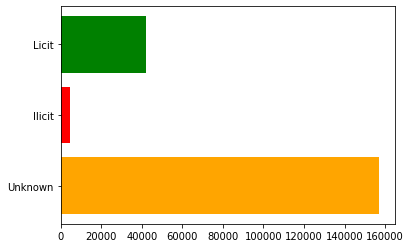

In [9]:
group_class = df_classes.groupby('class').count()
plt.barh(['Unknown', 'Ilicit', 'Licit'], group_class['txId'].values, color=['orange', 'r', 'g'] )

* Number of transactions per Time step

Text(0.5, 1.0, 'Number of transactions by Time step')

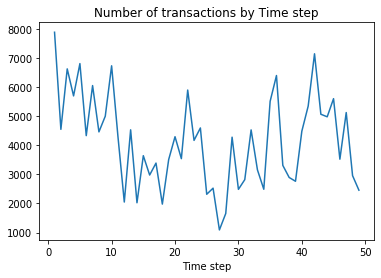

In [10]:
group_feature = df_features.groupby('Time step').count()
group_feature['txId'].plot()
plt.title('Number of transactions by Time step')

* Number of transactions per class and timestep

In [11]:
# Merge Class and features
df_class_feature = pd.merge(df_classes, df_features )
df_class_feature.head()

,txId,class,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,3,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,3,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,3,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,3,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [12]:
group_class_feature = df_class_feature.groupby(['Time step', 'class']).count()
#plt.barh(['Unknown', 'Ilicit', 'Licit'], group_class['txId'].values, color=['orange', 'r', 'g'] )
group_class_feature = group_class_feature['txId'].reset_index().rename(columns={'txId': 'count'})#unstack()
group_class_feature.head()

,Time step,class,count
0,1,3,5733
1,1,1,17
2,1,2,2130
3,2,3,3427
4,2,1,18


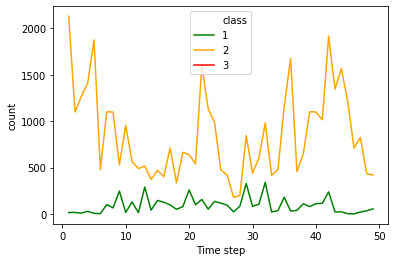

In [13]:
sns.lineplot(x='Time step', y='count', hue='class', data = group_class_feature, palette=['g', 'orange', 'r'] )

Text(0.5, 0, 'Time step')

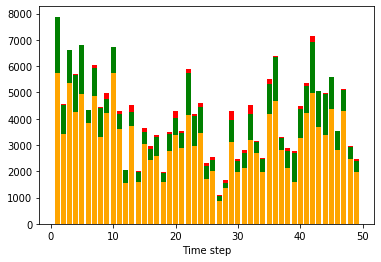

In [14]:
class1 = group_class_feature[group_class_feature['class'] == '1']
class2 = group_class_feature[group_class_feature['class'] == '2']
class3 = group_class_feature[group_class_feature['class'] == 3 ]

p1 = plt.bar(class3['Time step'], class3['count'], color = 'orange')

p2 = plt.bar(class2['Time step'], class2['count'], color='g',
             bottom=class3['count'])

p3 = plt.bar(class1['Time step'], class1['count'], color='r',
             bottom=np.array(class3['count'])+np.array(class2['count']))

plt.xlabel('Time step')


<a id='graphs'></a>
# Graphs
* Ilicit transactions at time step 20

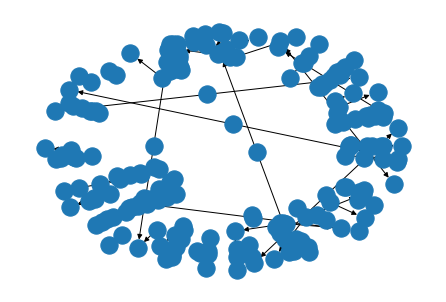

In [15]:
ilicit_ids = df_class_feature.loc[(df_class_feature['Time step'] == 20) & (df_class_feature['class'] == '1'), 'txId']
ilicit_edges = df_edges.loc[df_edges['txId1'].isin(ilicit_ids)]

graph = nx.from_pandas_edgelist(ilicit_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(graph)
nx.draw(graph, with_labels=False, pos=pos)

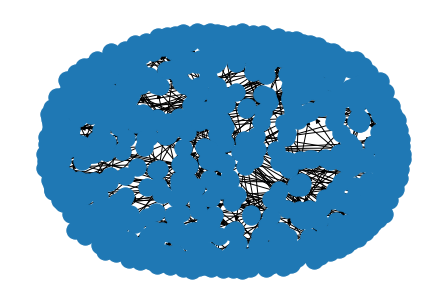

In [16]:
licit_ids = df_class_feature.loc[(df_class_feature['Time step'] == 20) & (df_class_feature['class'] == '2'), 'txId']
licit_edges = df_edges.loc[df_edges['txId1'].isin(licit_ids)]

graph = nx.from_pandas_edgelist(licit_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(graph)
nx.draw(graph, with_labels=False, pos=pos)

<a id='prediction'></a>
# Prediction of ilicit transactions
## Import packages

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

## Initial Data
* First we pick the class 1 or 2 transactions only

In [18]:
selected_ids = df_class_feature.loc[(df_class_feature['class'] != 3), 'txId']
df_edges_selected = df_edges.loc[df_edges['txId1'].isin(selected_ids)]
df_classes_selected = df_classes.loc[df_classes['txId'].isin(selected_ids)]
df_features_selected = df_features.loc[df_features['txId'].isin(selected_ids)]

# Merge Class and features
df_class_feature_selected = pd.merge(df_classes_selected, df_features_selected )
df_class_feature_selected.head()

,txId,class,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
1,232029206,2,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
2,232344069,2,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,27553029,2,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,3881097,2,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


In [19]:
X = df_class_feature_selected.drop(columns=['txId', 'class', 'Time step']) # drop class, text id and time step
y = df_class_feature_selected[['class']]

# in this case, class 2 corresponds to licit transactions, we chang this to 0 as our interest is the ilicit transactions
y = y['class'].apply(lambda x: 0 if x == '2' else 1 )

* Split train/test data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=15)

## Random Forest Classifier

In [21]:
model_RF = RandomForestClassifier().fit(X_train.values,y_train.values)
y_preds = model_RF.predict(X_test.values)

prec,rec,f1,num = precision_recall_fscore_support(y_test.values, y_preds)

print("Random Forest Classifier")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))

Random Forest Classifier
Precision:0.997 
Recall:0.888 
F1 Score:0.939


## Predicting 'unknown' transactions
* Selecting 'unknown' ids

In [22]:
unknown_ids = df_class_feature.loc[(df_class_feature['class'] == 3), 'txId']

df_edges_unknown = df_edges.loc[df_edges['txId1'].isin(unknown_ids)]
df_classes_unknown = df_classes.loc[df_classes['txId'].isin(unknown_ids)]
df_features_unknown = df_features.loc[df_features['txId'].isin(unknown_ids)]

* Predicting Class

In [23]:
X_unknown = df_features_unknown.drop(columns=['txId', 'Time step'])
y_unknown_preds = model_RF.predict(X_unknown.values)

* Replacing 'unknown' class with the predicted one

In [24]:
df_classes_unknown = df_classes_unknown.copy()
df_classes_unknown.loc[:, 'class'] = y_unknown_preds

* Merge class and features

In [25]:
df_class_feature_unknown = pd.merge(df_classes_unknown, df_features_unknown )
df_class_feature_unknown.head()

,txId,class,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,0,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,0,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,230460314,0,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
4,230459870,0,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540


## Predicted Graph

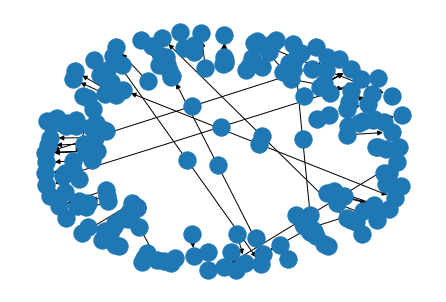

In [26]:
ilicit_ids = df_class_feature_unknown.loc[(df_class_feature_unknown['Time step'] == 20) & (df_class_feature_unknown['class'] == 1), 'txId']
ilicit_edges = df_edges_unknown.loc[df_edges_unknown['txId1'].isin(ilicit_ids)]

graph = nx.from_pandas_edgelist(ilicit_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(graph)
nx.draw(graph, with_labels=False, pos=pos)